In [7]:
#### Import
import numpy as np
import pickle as pkl
import scipy.interpolate as interp
import scipy.signal as signal
import scipy.optimize as opti
import scipy, sys, time
import matplotlib.pyplot as plt
from matplotlib import mlab as mlab
from matplotlib.mlab import psd
from tqdm import tqdm
from joblib import Parallel, delayed
import multiprocessing

import sys
sys.path.append('/home/analysis_user/New_trap_code/Tools/')
import BeadDataFile
from discharge_tools import load_dir
# some settings for standardized figures

plt.rcParams["figure.figsize"] = (16,12)
plt.rcParams['font.size'] = (24)
plt.rcParams['xtick.labelsize']="medium"
plt.rcParams['text.usetex'] = False
# coding: utf-8

# ### Notebook to create the utility file for the signal model input ###

#### Import

from bisect import bisect_left
sys.path.append('/home/analysis_user/New_trap_code/Tools/')
import BeadDataFile
from discharge_tools import load_dir
lambdas = np.logspace(-6.3, -3, 100)
sep_list = np.arange(0.0e-6,100e-6,0.5e-6)
height_list = np.arange(-15.0e-6,15.0e-6,0.5e-6)
### define functions


def take_closest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        return after
    else:
        return before



### part 1:load files

## load the data dictionary file (its usually of the form results_dic[rbead][sep][height][yuklambda])

def load_file(separation,height,lambda_par=1e-5,alpha=1):
    try:
        #print(height)
        res_dict_side_by_side = pkl.load( open('/home/analysis_user/New_trap_code/SensitivityFramework/results/simulation/rbead_2.4e-06_sep_%4.1e_height_%4.1e.p' % (separation,height) ,'rb'))
    except:
        print("Your choice of separation or height is not existing")
        val2 = take_closest(sep_list, separation)
        val3 = take_closest(height_list, height)
        separation=val2  
        height=val3
        print("Taking %4.1e for separation" %val2)
        print("Taking %4.1e for height" %val3)
        res_dict_side_by_side = pkl.load( open('/home/analysis_user/New_trap_code/SensitivityFramework/results/simulation/rbead_2.4e-06_sep_%4.1e_height_%4.1e.p' %(separation,height), 'rb'))
    try:
        res_dict_side_by_side[2.4e-6][separation][height][lambda_par][0]        
    except:
        print("Your choice of lambda is not existing")
        val = take_closest(lambdas, lambda_par)
        lambda_par=val  
        print("Taking %2.2e for lambda" %val)
    for item in res_dict_side_by_side[2.4e-6]:
        print("A separation of %2.2e is selected" %item)
        separation=item # as separation is saved differently here than in the file name
    for item2 in res_dict_side_by_side[2.4e-6][separation]:
        #print(res_dict_side_by_side[2.4e-6][separation])
        height=item2
        print("A height of %2.2e is selected" %item2)      
    force_x = res_dict_side_by_side[2.4e-6][separation][height][lambda_par][0] # force in direction of the sphere
    force_y = res_dict_side_by_side[2.4e-6][separation][height][lambda_par][1] # force in direction perpendicular to the sphere
    force_z = res_dict_side_by_side[2.4e-6][separation][height][lambda_par][2] # force in z-direction
    force_x_yuk = alpha*res_dict_side_by_side[2.4e-6][separation][height][lambda_par][3] # force by the yukawa potential , x
    force_y_yuk = alpha*res_dict_side_by_side[2.4e-6][separation][height][lambda_par][4] # force by the yukawa potential , y
    force_z_yuk = alpha*res_dict_side_by_side[2.4e-6][separation][height][lambda_par][5] # force by the yukawa potential , z
    pos = res_dict_side_by_side["posvec"] # get the position of the bead from the dictionary
    force_list = [force_x,force_y,force_z,force_x_yuk,force_y_yuk,force_z_yuk]
    return pos,force_list

### part 2: conversion of movement between the domains
# determine the center position of the attractor at a given time

def force_at_position(direction,pos,force_list,yuk_or_grav="yuk"):
    if(yuk_or_grav=="yuk"):
        if(direction=="x"):
            force_vec = force_list[3]
        if(direction=="y"):
            force_vec = force_list[4]
        if(direction=="z"):
            force_vec = force_list[5]
    if(yuk_or_grav=="grav"):
        if(direction=="x"):
            force_vec = force_list[0]
        if(direction=="y"):
            force_vec = force_list[1]
        if(direction=="z"):
            force_vec = force_list[2]        
    return force_vec




# triang
def position_at_time_tri_function(stroke,time,frequency,width=0.5):
    pos_at_time=stroke/2*signal.sawtooth(2 * np.pi * frequency * time+np.pi/2,width=width)
    return pos_at_time

# determine the force for a given point in time using the transformation to position

## sinusoidal movement
def force_at_a_time_sin_function(stroke,time,frequency,pos_vec,force_vec):
    osci_pos = position_at_time_sin_function(stroke,time,frequency)
    return np.interp(osci_pos,pos_vec,force_vec, left=None, right=None, period=None)

## triangle movement
def force_at_a_time_tri_function(stroke,time,frequency,pos_vec,force_vec,width=0.5):
    osci_pos_triang =  position_at_time_tri_function(stroke,time,frequency,width=width)
    return np.interp(osci_pos_triang,pos_vec,force_vec, left=None, right=None, period=None)

# use those two for most of your applications

def force_vs_position(separation,height,direction,lambda_par,yuk_or_grav="yuk",alpha=1):
    pos,force_list = load_file(separation,height,lambda_par,alpha)
    force = force_at_position(direction,pos,force_list,yuk_or_grav)
    return pos,force

def force_vs_time(separation,height,stroke,frequency,direction,lambda_par,yuk_or_grav="yuk",alpha=1):
    pos,force_list = load_file(separation,height,lambda_par,alpha)
    force_vec = force_at_position(direction,pos,force_list,yuk_or_grav="yuk")
    force = force_at_a_time_sin_function(stroke,time,frequency,pos,force_vec)
    return time,force

In [8]:
pos,force= load_file(5e-6,0,5e-6)

Your choice of separation or height is not existing
Taking 5.0e-06 for separation
Taking 8.5e-21 for height
Your choice of lambda is not existing
Taking 5.01e-06 for lambda
A separation of 5.00e-06 is selected
A height of 8.47e-21 is selected


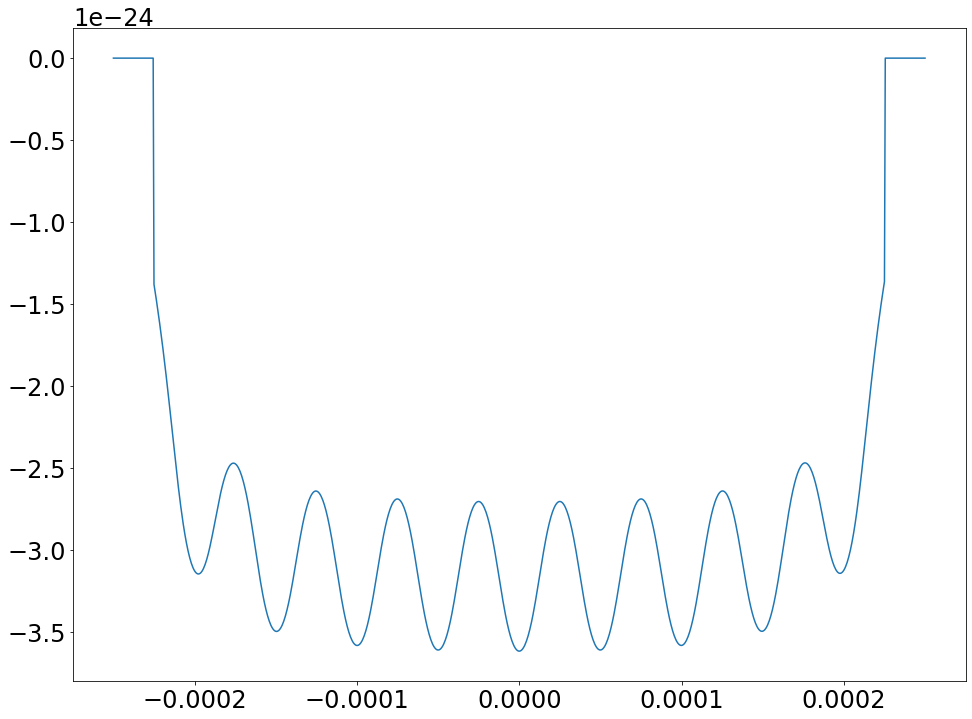

In [9]:
plt.plot(pos,force[0])

In [32]:
# sine
def position_at_time_sin_function(stroke,time,frequency,offset_y): 
    pos_at_time = stroke/2*np.sin(2*np.pi*time*frequency)+offset_y
    return pos_at_time

In [25]:
def force_vs_position(separation,height,direction,lambda_par,yuk_or_grav="yuk",alpha=1):
    pos,force_list = load_file(separation,height,lambda_par,alpha)
    force = force_at_position(direction,pos,force_list,yuk_or_grav)
    return pos,force

Your choice of separation or height is not existing
Taking 5.0e-06 for separation
Taking 8.5e-21 for height
Your choice of lambda is not existing
Taking 5.01e-06 for lambda
A separation of 5.00e-06 is selected
A height of 8.47e-21 is selected


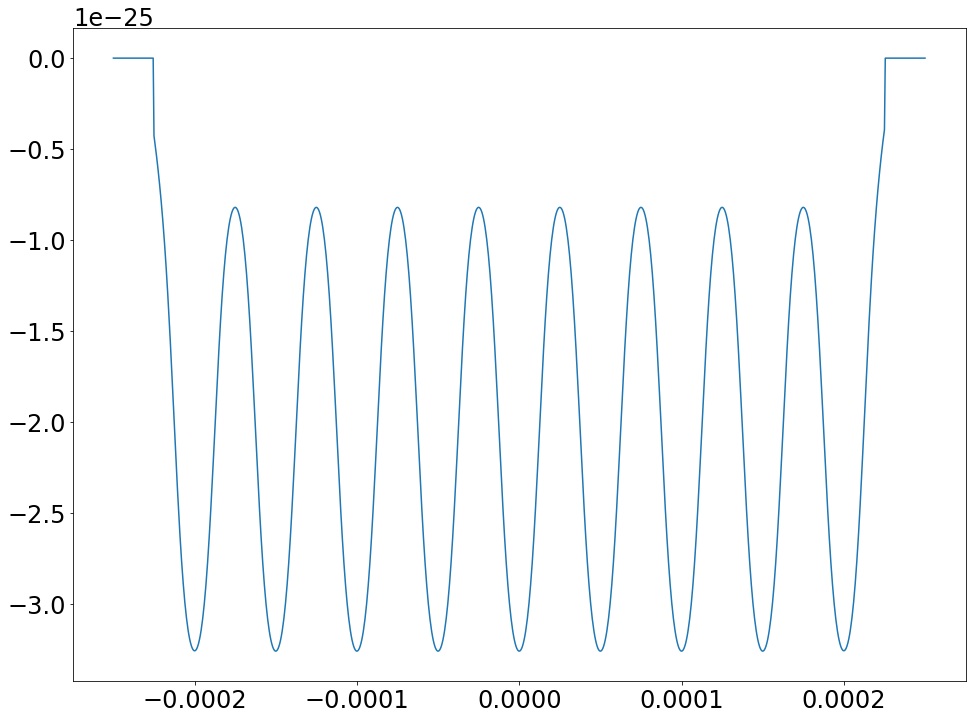

In [29]:
pos,force = force_vs_position(5e-6,0,"x",5e-6)
plt.plot(pos,force)

In [31]:
def force_at_a_time_sin_function(stroke,time,frequency,pos_vec,force_vec,offset_y):
    osci_pos = position_at_time_sin_function(stroke,time,frequency,offset_y)
    return np.interp(osci_pos,pos_vec,force_vec, left=None, right=None, period=None)


Your choice of separation or height is not existing
Taking 5.0e-06 for separation
Taking 8.5e-21 for height
Your choice of lambda is not existing
Taking 5.01e-06 for lambda
A separation of 5.00e-06 is selected
A height of 8.47e-21 is selected


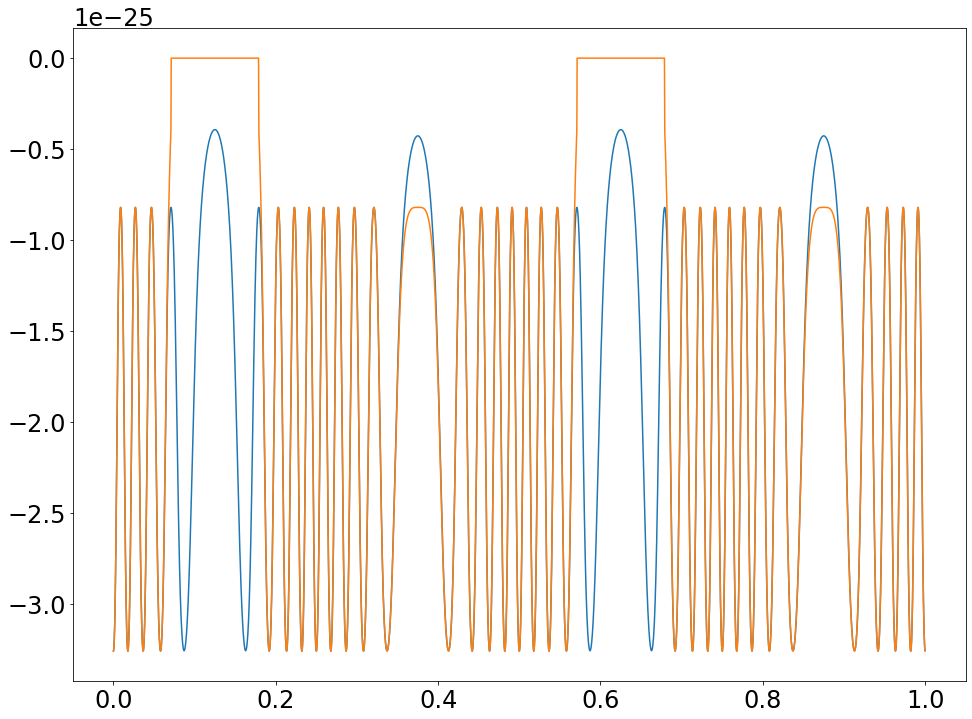

In [66]:
int_time =1 
sampling_frequency = 5000 # should be 5000 
time = np.arange(0,int_time,1/sampling_frequency) # make a time array
pos,force = force_vs_position(5e-6,0,"x",5e-6)
pos_vec = pos
force_vec = force
offset_y1 = 0e-6
offset_y2 = 50e-6

time_force = force_at_a_time_sin_function(450e-6,time,2,pos_vec,force_vec,offset_y1)
time_force2 = force_at_a_time_sin_function(450e-6,time,2,pos_vec,force_vec,offset_y2)
plt.plot(time,time_force)
plt.plot(time,time_force2)

In [ ]:
def force_vs_time(separation,height,stroke,frequency,direction,lambda_par,yuk_or_grav="yuk",alpha=1):
    pos,force_list = load_file(separation,height,lambda_par,alpha)
    force_vec = force_at_position(direction,pos,force_list,yuk_or_grav="yuk")
    force = force_at_a_time_sin_function(stroke,time,frequency,pos,force_vec)
    return time,force